In [1]:
## TODO: ZIFA (https://github.com/epierson9/ZIFA/blob/master/ZIFA/ZIFA.py) looks well adapted to this data distribution
# instead of quantile normalization -> PCA

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import qnorm
import sklearn.preprocessing as sklp
import sklearn.decomposition as skld
#from sklearn.preprocessing import StandardScaler


In [8]:
## 

def load_data(file='../data/Deobrat dataset.xlsx'):
    # Read table
    tbl = pd.read_excel(file)
    
    # Get metadata
    feature_metadata = pd.DataFrame(data=tbl.KEGG)
    tbl = tbl.drop('KEGG',axis=1)
    sample_metadata = pd.DataFrame(index=tbl.columns)
    sample_metadata['cell_line']=sample_metadata.index.map(lambda x: '387' if '387' in x else '3565')
    sample_metadata['cell_type']=sample_metadata.index.map(lambda x: 'DGC' if 'DGC' in x else 'GSC')
    sample_metadata['sample']=sample_metadata.cell_line+'_'+sample_metadata.cell_type
    
    # Are the names unique?
    if (sum(tbl.NAME.duplicated())) == 0:
        print("No duplicate features.")
        tbl = tbl.set_index('NAME')
    else:
        print("Duplicated features:")
        print(tbl.NAME.duplicated)
        
    # Any missing data?
    if not tbl.isna().any().any():
        print('No missing data.')
    else:
        a=len(tbl)
        tbl=tbl.dropna(axis=1)
        print(f'Dropping {str(len(tbl)-a)} rows missing data.')
        
    # Any zeros?
    
    print(f"Data shape: {tbl.shape[0]} features by {tbl.shape[1]} samples.")
    return (tbl, sample_metadata, feature_metadata)

def visualize_counts_histogram(tbl):
    data = tbl.to_numpy()
    sns.histplot(data.flatten(),bins=100)
    
def preprocess_counts(tbl):
    
    # Get a sense of the raw data distribution
    plt.figure()
    visualize_counts_histogram(tbl) # data is very zero-centered with a few high outliers.
    
    # Log-transform
    tbl = np.log2(tbl)
    plt.figure()
    visualize_counts_histogram(tbl)
    # Data are now roughly zero-inflated negative binomial (ZINB) distributed.
    
    # Quantile normalize
    ##tbl = qnorm.quantile_normalize(tbl)
    ##plt.figure()
    ##visualize_counts_histogram(tbl)
    
    return tbl

def quantile_norm(tbl):
    tbl = qnorm.quantile_normalize(tbl)
    plt.figure()
    visualize_counts_histogram(tbl)
    return tbl

def PCA(tbl,sample_metadata,n_components=2):
    scaled_values = sklp.StandardScaler().fit_transform(tbl.transpose()) # StandardScaler returns ndarray
    pca = skld.PCA(n_components)
    principal_components = pca.fit_transform(scaled_values)
    feature_names = map(lambda x: f'PC{x}', range(1,n_components+1)) # PC1, PC2...
    tbl = pd.DataFrame(data=principal_components, columns=feature_names, index=tbl.columns)
    tbl.PC1 = -tbl.PC1 #(PC sign is arbitrary and J. wants them facing the other way)
    plt.figure()
    sns.scatterplot(x=tbl.PC1, y=tbl.PC2, style=sample_metadata.cell_line,hue=sample_metadata.cell_type,legend=True,
                   palette=['blue','red'])
    #plt.legend(title='Cell',labels=sample_metadata['sample'].unique())
    #plt.show(g)
    plt.savefig('../out/PCA.svg')
    plt.savefig('../out/PCA.png')
    return tbl

def outlier(array):
    '''
    Implements https://www.statisticshowto.com/statistics-basics/find-outliers/
    '''
    #array=np.array(array)
    l,m,h = np.quantile(array,q=[0.25,0.5,0.75])
    iqr = h-l
    h_ = h+1.5*iqr
    l_ = l-1.5*iqr
    sns.boxplot(array)
    return (array < l_) | (array > h_)

def clustermap(tbl,method='ward',metric='euclidean'):
    scaled_values = sklp.StandardScaler().fit_transform(tbl.transpose()) # StandardScaler returns ndarray
    tbl = pd.DataFrame(data=scaled_values.transpose(), columns=tbl.columns, index=tbl.index)
    sns.clustermap(data=tbl,method=method,metric=metric,cmap='coolwarm')
    plt.savefig('../out/clustermap.svg')
    plt.savefig('../out/clustermap.png')

No duplicate features.
No missing data.
Data shape: 260 features by 16 samples.


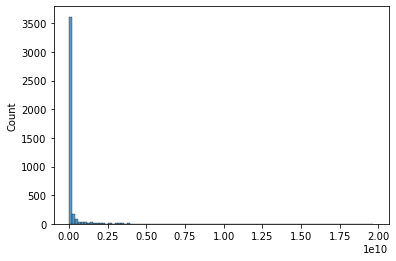

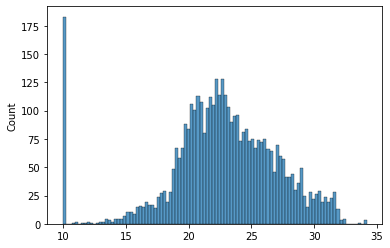

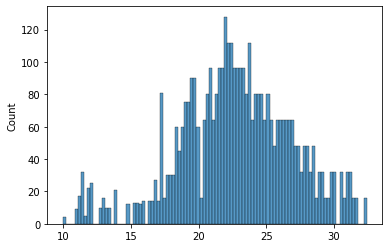

In [4]:
(data, sample_metadata, feature_metadata) = load_data()
data = preprocess_counts(data)
df = quantile_norm(data)

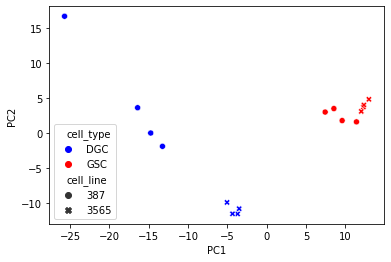

In [5]:
pcs = PCA(df,sample_metadata)

/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


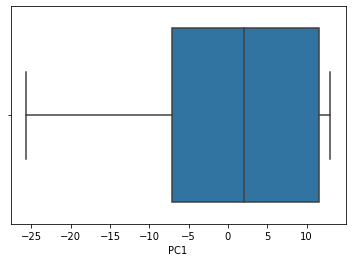

In [6]:
outlier(pcs.PC1)
plt.savefig('../out/PC1_boxplot.svg')

/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


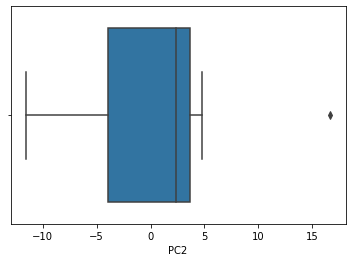

In [7]:
outlier(pcs.PC2)
plt.savefig('../out/PC2_boxplot.svg')

In [10]:
df = 

,II_D01_387_DGC_1,II_D02_387_DGC_2,II_D03_387_DGC_3,II_D04_387_DGC_4,II_D09_3565_DGC_1,II_D10_3565_DGC_2,II_D11_3565_DGC_3,II_D12_3565_DGC_4,II_D05_387_GSC_1,II_D06_387_GSC_2,II_D07_387_GSC_3,II_D08_387_GSC_4,II_D13_3565_GSC_1,II_D14_3565_GSC_2,II_D15_3565_GSC_3,II_D16_3565_GSC_4
NAME,,,,,,,,,,,,,,,,
N-phosphocreatinate,26.612116,26.378517,26.820816,25.052484,27.608309,27.530592,27.530592,27.145176,21.195765,20.251038,20.752480,20.715124,11.373563,11.851820,11.373563,11.851820
fructoseglycine,23.920752,23.118244,24.058360,23.349610,24.935584,23.738892,24.506513,22.926584,16.899303,17.522218,16.516309,11.373563,11.373563,11.851820,11.373563,11.851820
5-amino-1-(5-phospho-D-ribosyl)imidazole,27.530592,30.040064,28.582726,25.560324,28.939342,25.949195,28.737505,30.538763,17.887258,20.968565,19.419982,19.537626,16.723152,18.081760,18.326482,18.412604
C20H30O4(18),20.526862,20.526862,19.845860,22.471084,19.454570,20.673578,17.680266,19.277470,13.507501,11.133170,13.507501,11.373563,11.373563,11.851820,11.373563,11.851820
5-Hydroxyisourate,21.339030,20.583320,21.299533,21.662952,19.212627,19.391820,19.454570,19.391820,11.038163,11.133170,12.196334,11.373563,11.373563,11.851820,11.373563,11.851820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTP,13.850266,16.899303,12.961343,17.350567,19.009910,19.977939,18.872591,15.179816,23.150644,24.398714,23.118244,22.958565,26.715255,24.745567,24.373006,24.373006
Coenzyme A,13.850266,12.089277,12.961343,17.350567,11.280097,10.997624,10.997624,12.689400,19.454570,20.715124,19.164056,19.009910,21.030679,21.462895,20.752480,20.864001
Biotin,18.412604,17.024264,17.887258,20.526862,14.701301,11.489899,13.184615,14.701301,22.093449,22.222740,22.738876,20.251038,23.316763,23.349610,22.597330,22.775313


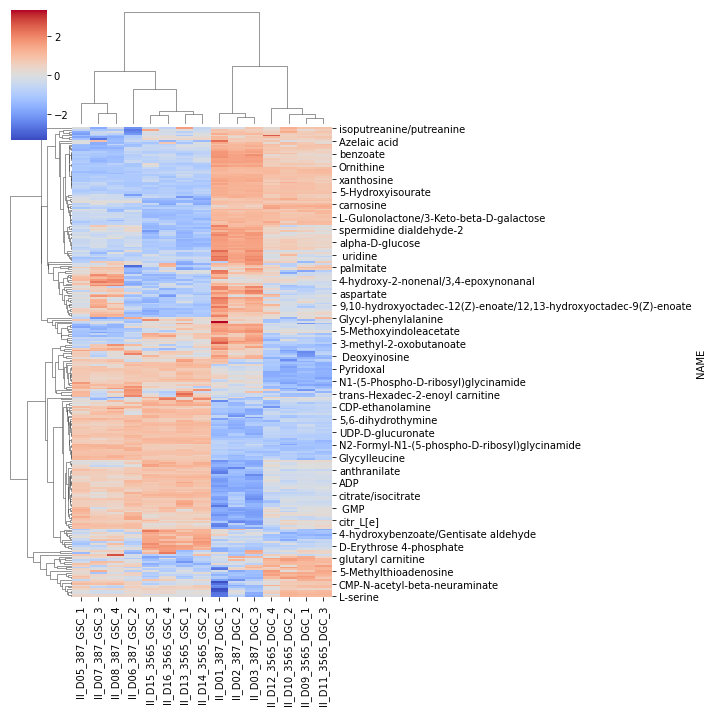

In [12]:
clustermap(df.drop('II_D04_387_DGC_4',axis='columns'),method='average',metric='cosine')

In [ ]:
#clustermap(df,method='average',metric='correlation')

In [ ]:
#clustermap(data,method='average',metric='correlation')